# 1.Import the required libraries and load the training and testing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

### Load datasets

In [2]:
train_X = pd.read_csv('train.csv')
train_y = pd.read_csv('train_label.csv')
test_X = pd.read_csv('test.csv')
test_y = pd.read_csv('test_label.csv')

In [3]:
df = train_X.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012


# 2.Analyze the dataset and write your observations
    a.Check the shape of the training and testing set
    b.Print the data types of each column
    c.Check the missing values present in the datase

In [4]:
print(f"Shape of train_X: {train_X.shape}")
print(f"Shape of train_y: {train_y.shape}")
print(f"Shape of test_X: {test_X.shape}")
print(f"Shape of test_y: {test_y.shape}")

Shape of train_X: (8708, 9)
Shape of train_y: (8708, 1)
Shape of test_X: (2178, 9)
Shape of test_y: (2178, 1)


## 2.b Data types of each column

In [5]:
print(train_X.info())
print(train_y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8708 non-null   object 
 1   season      8708 non-null   object 
 2   holiday     8708 non-null   int64  
 3   workingday  8708 non-null   int64  
 4   weather     8708 non-null   object 
 5   temp        8708 non-null   float64
 6   atemp       8708 non-null   float64
 7   humidity    8708 non-null   int64  
 8   windspeed   8708 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 612.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  8708 non-null   int64
dtypes: int64(1)
memory usage: 68.2 KB
None


## 2.c Check for missing values

In [6]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [7]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

### Observation: There are no missing values

# 3.Perform Feature Engineering:
    a.Create new columns date, hour,weekDay,monthfrom datetime column
    b.Coerce the datatype of season,holiday,workingday,and weather to category
    c.Drop the datetimecolumn as we have already extracted useful features from i

## 3.a Extracing datetime to year, month, date, hr, min sec

In [8]:
df['datetime'] = pd.to_datetime(df.datetime)

df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month 
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour 
df['minute'] = df.datetime.dt.minute
df['second'] = df.datetime.dt.second

## Splitting weather into two features

In [9]:
print(df['weather'].unique())
df['weather'] = df['weather'].str.replace(',','+')
df[['weather1','weather2']] = df['weather'].str.split('+', 2, expand=True)

[' Clear + Few clouds' ' Light Snow, Light Rain' ' Mist + Cloudy '
 ' Heavy Rain + Thunderstorm ']


In [10]:
#Dropping off the weather
df.drop(columns=['weather'], axis=1, inplace=True)

# Trimming the data

In [11]:
categorical = ['season', 'weather1', 'weather2']
for column in categorical:
    df[column] = df[column].str.strip()

In [12]:
df.head()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,weather1,weather2
0,2012-05-02 19:00:00,Summer,0,1,22.14,25.760,77,16.9979,2012,5,2,19,0,0,Clear,Few clouds
1,2012-09-05 04:00:00,Fall,0,1,28.70,33.335,79,19.0012,2012,9,5,4,0,0,Clear,Few clouds
2,2011-01-13 09:00:00,Spring,0,1,5.74,6.060,50,22.0028,2011,1,13,9,0,0,Clear,Few clouds
3,2011-11-18 16:00:00,Winter,0,1,13.94,16.665,29,8.9981,2011,11,18,16,0,0,Clear,Few clouds
4,2011-09-13 13:00:00,Fall,0,1,30.34,33.335,51,19.0012,2011,9,13,13,0,0,Clear,Few clouds


## 3.b Coerce the datatype of season,holiday,workingday,and weather to category

In [13]:
df = df.astype({'season':'category', 
                'holiday':'category', 
                'workingday':'category',
                'weather1':'category',
               'weather2':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    8708 non-null   datetime64[ns]
 1   season      8708 non-null   category      
 2   holiday     8708 non-null   category      
 3   workingday  8708 non-null   category      
 4   temp        8708 non-null   float64       
 5   atemp       8708 non-null   float64       
 6   humidity    8708 non-null   int64         
 7   windspeed   8708 non-null   float64       
 8   year        8708 non-null   int64         
 9   month       8708 non-null   int64         
 10  day         8708 non-null   int64         
 11  hour        8708 non-null   int64         
 12  minute      8708 non-null   int64         
 13  second      8708 non-null   int64         
 14  weather1    8708 non-null   category      
 15  weather2    8708 non-null   category      
dtypes: category(5), datetime

## 3.c Checking if minute and seconds are null or empty if so then dropping off

In [14]:
print(df['minute'].unique())
print(df['second'].unique())

df.drop(columns=['datetime','minute', 'second'], axis=1, inplace=True)

[0]
[0]


In [15]:
df.head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,weather1,weather2
0,Summer,0,1,22.14,25.760,77,16.9979,2012,5,2,19,Clear,Few clouds
1,Fall,0,1,28.70,33.335,79,19.0012,2012,9,5,4,Clear,Few clouds
2,Spring,0,1,5.74,6.060,50,22.0028,2011,1,13,9,Clear,Few clouds
3,Winter,0,1,13.94,16.665,29,8.9981,2011,11,18,16,Clear,Few clouds
4,Fall,0,1,30.34,33.335,51,19.0012,2011,9,13,13,Clear,Few clouds


# 4. Perform Outlier Analysis

### a.Plot Box plotsacross various features like season, hour of the day, working_day,etc to see if there are any Outlierand note downyour inference

Boxplot of temp


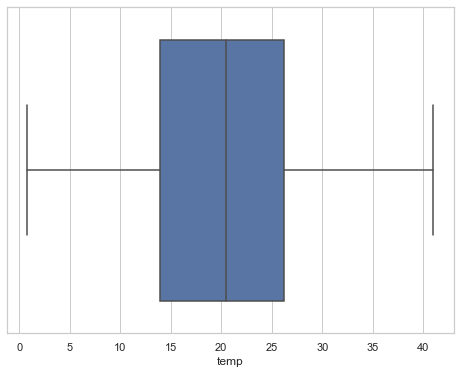

Boxplot of atemp


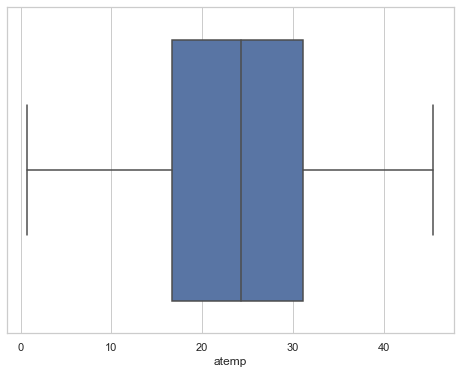

Boxplot of humidity


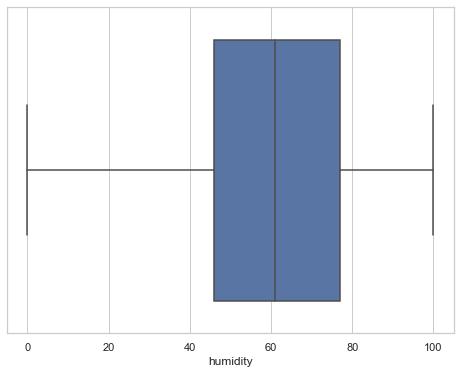

Boxplot of windspeed


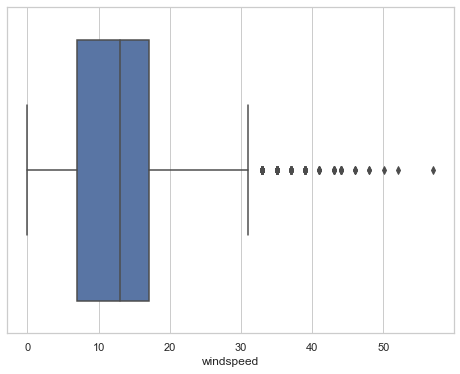

Boxplot of year


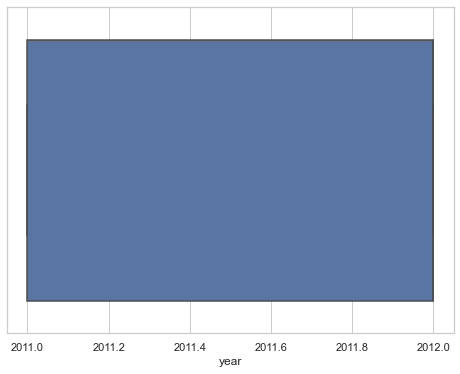

Boxplot of month


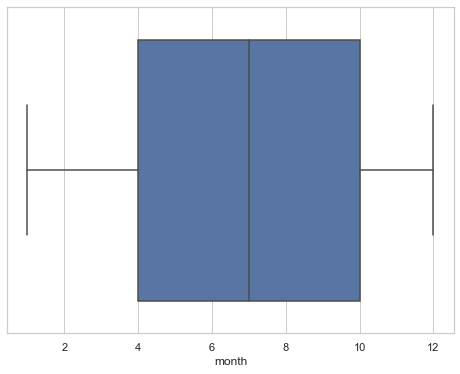

Boxplot of day


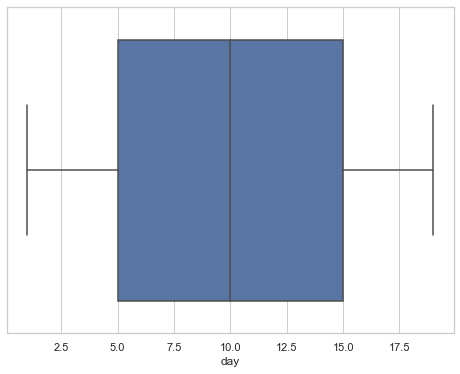

Boxplot of hour


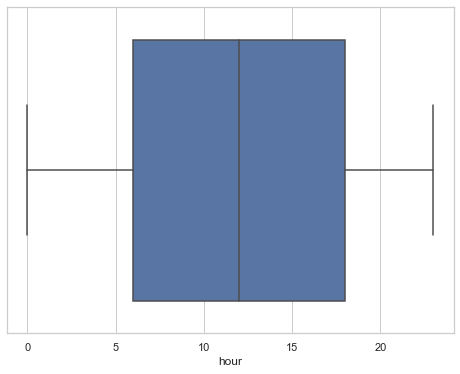

In [16]:
for column in df.select_dtypes(exclude=['category']):
    print(f'Boxplot of {column}')
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    sns.boxplot(df[column])
    plt.show()

### Observation: windspeed has some outliers

In [17]:
# Checking how many are greater than 30
windspeed_count = df[df['windspeed'] > 30].shape[0]
print(f"Shape of outliers for windspeed: {windspeed_count}")
print(f"% of outliers for windspeed: {(windspeed_count*100)/df.shape[0]}")

Shape of outliers for windspeed: 354
% of outliers for windspeed: 4.065227377124483


## 4.b Removing outliers

In [18]:
### Deleting the outliers for windspeed
df.drop(df[df['windspeed'] > 30].index, axis=0, inplace=True)

# Join train_label and train_X for data analysis

In [19]:
df['target'] = train_y
df.head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,weather1,weather2,target
0,Summer,0,1,22.14,25.760,77,16.9979,2012,5,2,19,Clear,Few clouds,504
1,Fall,0,1,28.70,33.335,79,19.0012,2012,9,5,4,Clear,Few clouds,5
2,Spring,0,1,5.74,6.060,50,22.0028,2011,1,13,9,Clear,Few clouds,139
3,Winter,0,1,13.94,16.665,29,8.9981,2011,11,18,16,Clear,Few clouds,209
4,Fall,0,1,30.34,33.335,51,19.0012,2011,9,13,13,Clear,Few clouds,184


# 5.Perform Correlation Analysis:
    a.Plot a correlation plot between "total booking" and ["temp","atemp","humidity","windspeed"]
    b.Write down your inference in the markdown cel

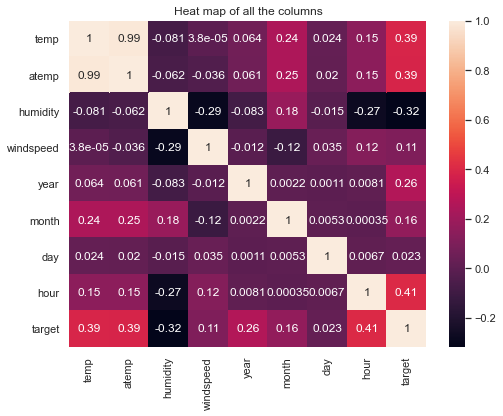

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.title('Heat map of all the columns')
plt.show()

### Observations: 

1. temp and atemp are highly correlated
2. target and hour are correlated
3. rest of them are not that correlated

# 6. Data Visualization

## 6.a target(total_booking) distribution and probability plot

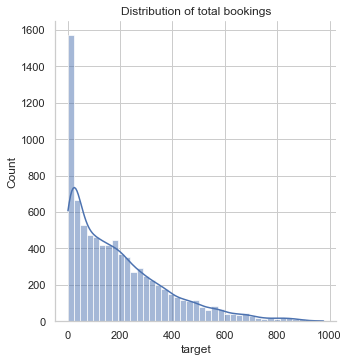

In [21]:
sns.displot(df['target'], kde=True)
plt.title('Distribution of total bookings')
plt.show()

# 6.b Comparing the columns with target variable

Distribution of: temp


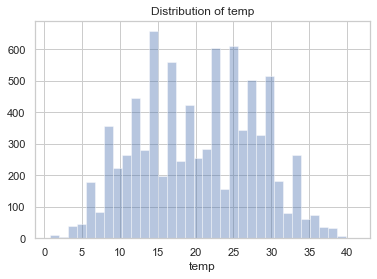

Distribution of: atemp


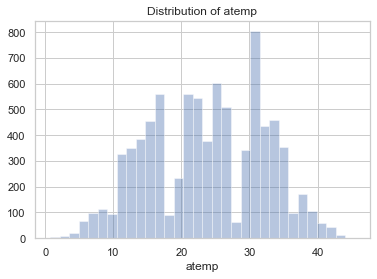

Distribution of: humidity


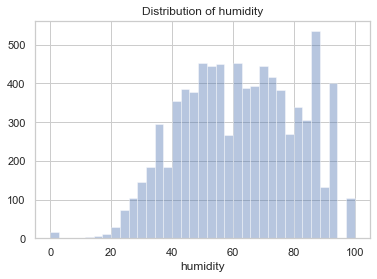

Distribution of: windspeed


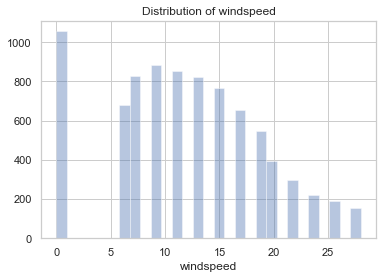

Distribution of: year


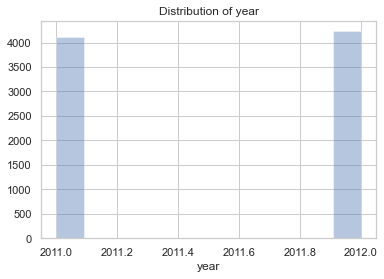

Distribution of: month


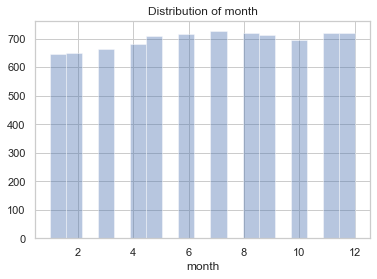

Distribution of: day


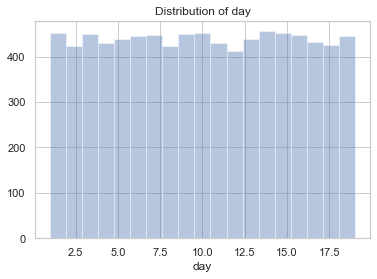

Distribution of: hour


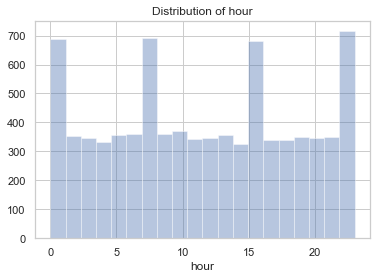

Distribution of: target


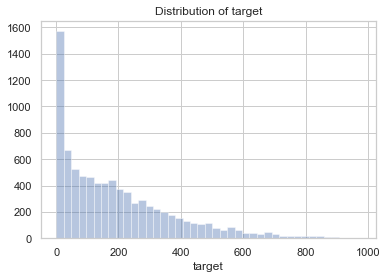

In [22]:
#Distribution of numerical columns
for column in df.select_dtypes(exclude=['object','category']):
    print(f'Distribution of: {column}')
    sns.distplot(df[column], kde=False)
    plt.xlabel(f'{column}')
    plt.title(f'Distribution of {column}')
    plt.show()

Scatter plot for :temp


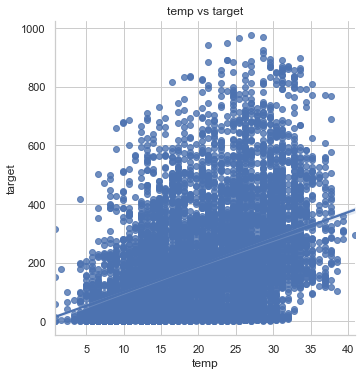

Scatter plot for :atemp


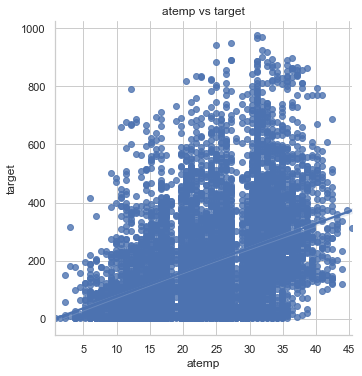

Scatter plot for :humidity


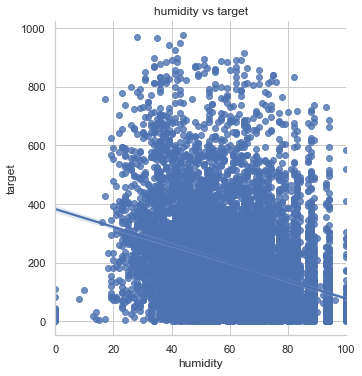

Scatter plot for :windspeed


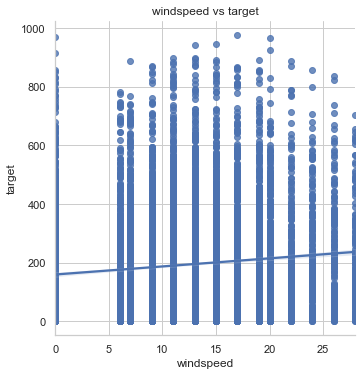

Scatter plot for :year


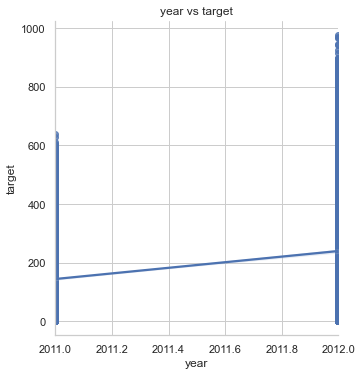

Scatter plot for :month


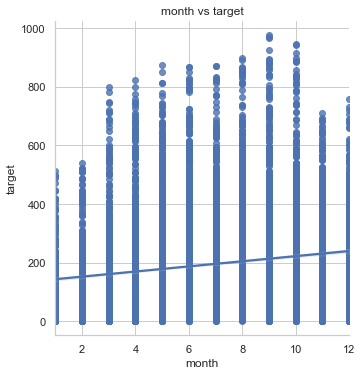

Scatter plot for :day


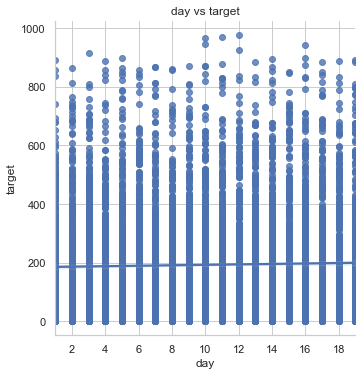

Scatter plot for :hour


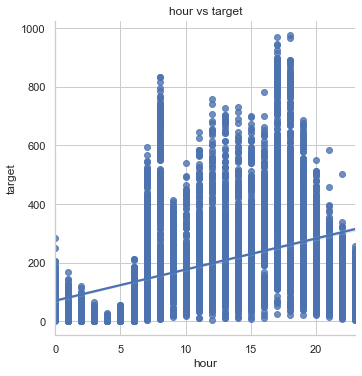

Scatter plot for :target


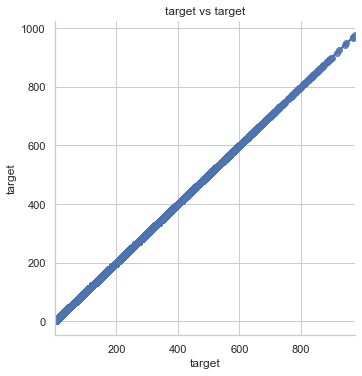

In [23]:
for column in df.select_dtypes(exclude=['object','category']):
    print(f'Scatter plot for :{column}')
    sns.lmplot(x=column, y='target', data=df)
    plt.xlabel(f'{column}')
    plt.ylabel('target')
    plt.title(f'{column} vs target')
    plt.show()

## 6.b Total bookings vs rest of the columns

### Observations: 
1. temperature has a positive trend with target
2. humidity has a negative trend with target
3. windsped has a positive trend with target
4. month and hour has a positive trend with target

In [24]:
print(df['season'].unique())
print(df['season'].describe())

['Summer', 'Fall', 'Spring', 'Winter']
Categories (4, object): ['Summer', 'Fall', 'Spring', 'Winter']
count     8354
unique       4
top       Fall
freq      2155
Name: season, dtype: object


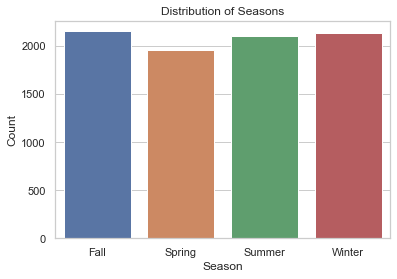

In [25]:
sns.countplot(df['season'])
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Distribution of Seasons')
plt.show()

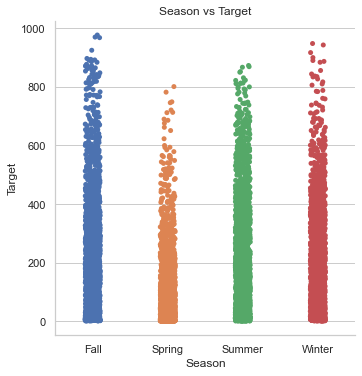

In [26]:
sns.catplot(x='season',y='target' ,data=df)
plt.xlabel('Season')
plt.ylabel('Target')
plt.title('Season vs Target')
plt.show()

##### Observation: There were more bookings during Fall and Winter

# Analysing holiday & workingday columns

In [27]:
print(df['holiday'].unique())
print(df['workingday'].unique())

[0, 1]
Categories (2, int64): [0, 1]
[1, 0]
Categories (2, int64): [1, 0]


### Checking for anomalies between holiday and working day
1. Holiday and workingday shouldn't be 1
2. Holiday and workingday shouldn't be 0

In [28]:
holiday_and_workingday = (df['holiday'] == 1) & (df['workingday'] == 1)
print(df[holiday_and_workingday])

Empty DataFrame
Columns: [season, holiday, workingday, temp, atemp, humidity, windspeed, year, month, day, hour, weather1, weather2, target]
Index: []


In [29]:
not_holiday_and_not_workingday = (df['holiday'] == 0) & (df['workingday'] == 0)
df[not_holiday_and_not_workingday].head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,weather1,weather2,target
6,Winter,0,0,24.60,29.545,73,12.9980,2012,10,6,9,Clear,Few clouds,395
8,Fall,0,0,27.06,31.060,61,7.0015,2012,7,14,4,Light Snow,Light Rain,9
9,Spring,0,0,12.30,15.150,56,11.0014,2011,2,6,18,Clear,Few clouds,78
12,Spring,0,0,18.86,22.725,38,26.0027,2011,3,13,13,Clear,Few clouds,221
16,Winter,0,0,26.24,30.305,65,16.9979,2012,10,6,11,Clear,Few clouds,647


In [30]:
holiday_count = sum(df['holiday'] == 1)
workingday_count = sum(df['workingday'] == 1)
holiday_count, workingday_count, holiday_count + workingday_count, df.shape[0]

(234, 5682, 5916, 8354)

### Observation: There are no records with both as 1

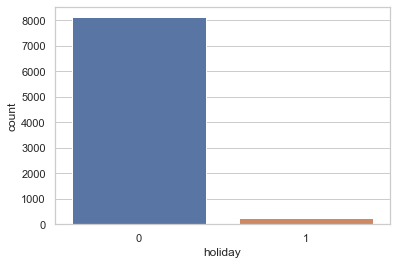

In [31]:
sns.countplot(df.holiday)
plt.show()


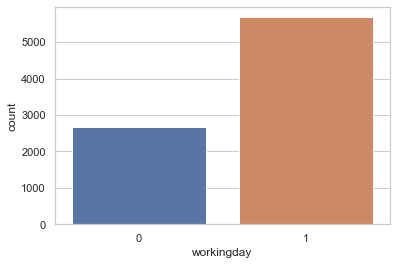

In [32]:
sns.countplot(df.workingday)
plt.show()

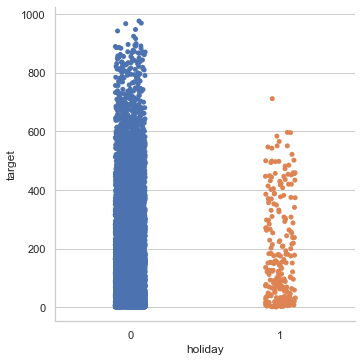

In [33]:
sns.catplot(x='holiday',y='target' ,data=df)
plt.show()

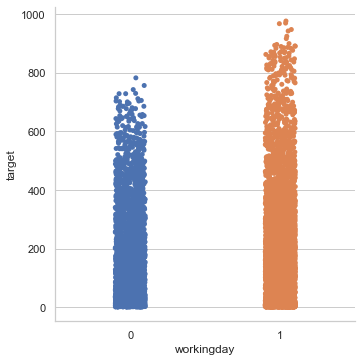

In [34]:
sns.catplot(x='workingday',y='target' ,data=df)
plt.show()

In [35]:
df.head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,weather1,weather2,target
0,Summer,0,1,22.14,25.760,77,16.9979,2012,5,2,19,Clear,Few clouds,504
1,Fall,0,1,28.70,33.335,79,19.0012,2012,9,5,4,Clear,Few clouds,5
2,Spring,0,1,5.74,6.060,50,22.0028,2011,1,13,9,Clear,Few clouds,139
3,Winter,0,1,13.94,16.665,29,8.9981,2011,11,18,16,Clear,Few clouds,209
4,Fall,0,1,30.34,33.335,51,19.0012,2011,9,13,13,Clear,Few clouds,184


# Dropping off ateam as temp is highly corelated with atemp

In [36]:
df.drop(columns=['atemp'], axis=1, inplace=True)

# Checking measures of central tendencies of all the columns

In [37]:
columns = ['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour']

for column in columns:
    print(f"{column}: Mean:{df[column].mean()}, \
          Median:{df[column].median()}, \
          Mode:{df[column].mode()[0]}, \
          Std:{df[column].std()}")

temp: Mean:20.323416327507793,           Median:20.5,           Mode:14.76,           Std:7.808894342411941
humidity: Mean:62.27531721331099,           Median:62.0,           Mode:88,           Std:18.928475234862347
windspeed: Mean:11.970250155614242,           Median:11.0014,           Mode:0.0,           Std:7.098595089721173
year: Mean:2011.506463969356,           Median:2012.0,           Mode:2012,           Std:0.4999881413241087
month: Mean:6.609528369643285,           Median:7.0,           Mode:7,           Std:3.4227337224118513
day: Mean:10.00047881254489,           Median:10.0,           Mode:14,           Std:5.480044422916695
hour: Mean:11.502513765860666,           Median:11.0,           Mode:10,           Std:6.930746747226513


In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,8354.0,20.323416,7.808894,0.82,13.9400,20.5000,26.2400,41.0000
humidity,8354.0,62.275317,18.928475,0.00,48.0000,62.0000,77.0000,100.0000
windspeed,8354.0,11.970250,7.098595,0.00,7.0015,11.0014,16.9979,27.9993
year,8354.0,2011.506464,0.499988,2011.00,2011.0000,2012.0000,2012.0000,2012.0000
month,8354.0,6.609528,3.422734,1.00,4.0000,7.0000,10.0000,12.0000
day,8354.0,10.000479,5.480044,1.00,5.0000,10.0000,15.0000,19.0000
hour,8354.0,11.502514,6.930747,0.00,6.0000,11.0000,18.0000,23.0000
target,8354.0,192.714149,181.852462,1.00,42.0000,147.0000,286.0000,977.0000


### Observation: There are no possible outliers as mean and median are nearly same

In [39]:
train_X.to_csv('data.csv', index=False)

# We could start machine learning

In [40]:
df.head()

,season,holiday,workingday,temp,humidity,windspeed,year,month,day,hour,weather1,weather2,target
0,Summer,0,1,22.14,77,16.9979,2012,5,2,19,Clear,Few clouds,504
1,Fall,0,1,28.70,79,19.0012,2012,9,5,4,Clear,Few clouds,5
2,Spring,0,1,5.74,50,22.0028,2011,1,13,9,Clear,Few clouds,139
3,Winter,0,1,13.94,29,8.9981,2011,11,18,16,Clear,Few clouds,209
4,Fall,0,1,30.34,51,19.0012,2011,9,13,13,Clear,Few clouds,184


# 7. Converting categorical variables into one hot encoder

In [41]:
#df_copy = df.copy()
#df = df_copy.copy()

In [42]:
categorical = ['season', 'weather1', 'weather2']
for column in categorical:    
    si = SimpleImputer(strategy='most_frequent')
    df[column] =si.fit_transform(df[[column]])

In [43]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
result = ohe.fit_transform(df[categorical])

In [44]:
columns = []
for categories in ohe.categories_:
    for col in categories:
        columns.append(col)
columns
result = pd.DataFrame(result, columns=columns, index=df.index)
print(result.shape, df.shape)
df.drop(columns=categorical, axis=1, inplace=True)
df = pd.concat([result,df], axis=1)
df.head()

(8354, 12) (8354, 13)


,Fall,Spring,Summer,Winter,Clear,Heavy Rain,Light Snow,Mist,Cloudy,Few clouds,...,holiday,workingday,temp,humidity,windspeed,year,month,day,hour,target
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,1,22.14,77,16.9979,2012,5,2,19,504
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,1,28.70,79,19.0012,2012,9,5,4,5
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,1,5.74,50,22.0028,2011,1,13,9,139
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,1,13.94,29,8.9981,2011,11,18,16,209
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,1,30.34,51,19.0012,2011,9,13,13,184


# 8. Splitting the dataset into train and test

In [45]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, train_size=0.7)

print(f"Shape of X_train: {X_train.shape[0]}")
print(f"Shape of y_train: {y_train.shape[0]}")
print(f"Shape of X_test: {X_test.shape[0]}")
print(f"Shape of y_test: {y_test.shape[0]}")

Shape of X_train: 5847
Shape of y_train: 5847
Shape of X_test: 2507
Shape of y_test: 2507


# 9. Fit various models (Random Forest Regressor, Ada Boost Regressor, BaggingRegressor, SVR, and K-Neighbors Regressor)

In [46]:
models = {'RFR': RandomForestRegressor(), 
         'ABR': AdaBoostRegressor(),
         'Bag': BaggingRegressor(),
         'SVR': LinearSVR(),
         'KNN': KNeighborsRegressor()}
mae = []
for model in models:
    m = models[model]
    m.fit(X_train, y_train)
    y_predict = m.predict(X_test)
    mae.append({'Model':model, 'RMSE':mean_squared_error(y_test, y_predict)})    

In [47]:
rmse_df = pd.DataFrame(mae, columns=['Model', 'RMSE'])
rmse_df.head()

,Model,RMSE
0,RFR,2196.738672
1,ABR,10835.196044
2,Bag,2428.637838
3,SVR,37377.878777
4,KNN,15172.527563


# 10. Factor plot to visualize the RMSE values achieved by different modeling algorithm

<Figure size 576x432 with 0 Axes>

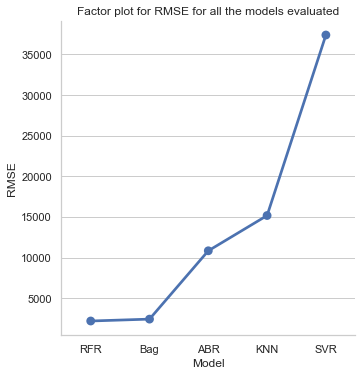

In [48]:
plt.figure(figsize=(8,6))
sns.factorplot(x='Model', y='RMSE',data = rmse_df.sort_values(by=['RMSE']))
plt.title('Factor plot for RMSE for all the models evaluated')
plt.show()

# 11. Perform Hyper-parameter tuning on the best model using GridSearchCVand print the best parameters using model.best_params_

In [49]:
indexes = train_X[train_X['windspeed'] > 30].index
train_X.drop(indexes, axis=0, inplace=True)
train_y.drop(indexes, axis=0, inplace=True)

# Splitting Weather into two categorical variables

In [50]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform
class WeatherTransformer(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        if 'weather' in x_dataset.columns:
            x_dataset['weather'] = x_dataset['weather'].str.replace(',','+')
            x_dataset[['weather1','weather2']] = x_dataset['weather'].str.split('+', 2, expand=True)
        return x_dataset


# Extracting multiple features from datetime

In [51]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform
class DateTimeEncoder(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        if 'datetime' in x_dataset.columns:
            x_dataset['datetime'] = pd.to_datetime(x_dataset['datetime'])
            x_dataset['year'] = x_dataset.datetime.dt.year
            x_dataset['month'] = x_dataset.datetime.dt.month 
            x_dataset['day'] = x_dataset.datetime.dt.day
            x_dataset['hour'] = x_dataset.datetime.dt.hour     
        
        return x_dataset
        

# Dropping of unwanted columns

In [52]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform
class DropColumns(BaseEstimator):

    def __init__(self):
        self.columns = ['datetime','atemp','weather']
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset:pd.DataFrame):
        for column in self.columns:
            if column in x_dataset.columns:
                x_dataset.drop(columns=[column], axis=1, inplace=True)        
        
        return x_dataset
        

In [53]:
feature_transformer = Pipeline(steps=[
                                ('split_weather', WeatherTransformer()),
                                 ('split_datetime', DateTimeEncoder()),
                                 ('drop',DropColumns())])

# Converting categorical variables into one hot encoder

In [54]:
categorical_features = ['season', 'weather1', 'weather2']

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

In [55]:
regressors = {'Linear': LinearRegression(), 
              'Lasso': Lasso(), 
              'Ridge': Ridge(), 
              'DecisionTree': DecisionTreeRegressor(),
              'SVR': LinearSVR(),
             'RandomForest': RandomForestRegressor(),
             'AdaBoost': AdaBoostRegressor(),
             'GBoost': GradientBoostingRegressor(),
             'Naive Bayes': GaussianNB(),
             'KNN': KNeighborsRegressor(),
             'SBD':SGDRegressor()}

In [56]:
regression_df = pd.DataFrame(columns=['Model', 'Score'])
for model in regressors:
    clf = Pipeline(steps=[('feature_transformer', feature_transformer),
                        ('preprocessor', preprocessor),
                      ('regression', regressors[model])])
    clf.fit(train_X, train_y)
    score = "%.3f" % clf.score(test_X, test_y)
    regression_df = regression_df.append({'Model':model, 'Score':score}, ignore_index=True)

In [57]:
regression_df.sort_values(by=['Score'], ascending=False)

,Model,Score
5,RandomForest,0.943
3,DecisionTree,0.888
7,GBoost,0.863
6,AdaBoost,0.679
9,KNN,0.500
1,Lasso,0.400
0,Linear,0.398
2,Ridge,0.398
4,SVR,0.020
8,Naive Bayes,0.000


In [58]:
kf = KFold(n_splits=5)

X = train_X
y = train_y

kf.get_n_splits(X)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [59]:
scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = Pipeline(steps=[('feature_transformer', feature_transformer),
                        ('preprocessor', preprocessor),
                      ('regression', RandomForestRegressor())])
    clf.fit(X_train, y_train)
    scores.append(float("%.3f" % clf.score(X_test, y_test)))
scores

[0.933, 0.943, 0.941, 0.941, 0.929]

In [60]:
print(f"Average Score: {np.round(np.average(scores),3)}")

Average Score: 0.937


In [61]:
pipeline = Pipeline(steps=[('feature_transformer', feature_transformer),
                        ('preprocessor', preprocessor),
                      ('clf', RandomForestRegressor())])


tuned_parameters = {'clf__bootstrap': [True, False],
 'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'clf__max_features': ['auto', 'sqrt'],
 'clf__min_samples_leaf': [1, 2, 4],
 'clf__min_samples_split': [2, 5, 10],
 'clf__n_estimators': [100]}

clf = GridSearchCV(pipeline, tuned_parameters, n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)
#score = "%.3f" % clf.score(test_X, test_y)
print("Best Params",clf.best_params_)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Best Params {'clf__bootstrap': True, 'clf__max_depth': 30, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [64]:
pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__bootstrap,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,4.159730,0.202084,0.067693,0.012247,True,30,auto,1,2,100,"{'clf__bootstrap': True, 'clf__max_depth': 30,...",0.929859,0.932243,0.943192,0.941371,0.936605,0.936654,0.005111,1
144,3.751997,0.277235,0.061008,0.001550,True,90,auto,1,2,100,"{'clf__bootstrap': True, 'clf__max_depth': 90,...",0.928645,0.931726,0.943744,0.941332,0.937189,0.936527,0.005671,2
126,3.396198,0.108138,0.062803,0.004309,True,80,auto,1,2,100,"{'clf__bootstrap': True, 'clf__max_depth': 80,...",0.928061,0.931195,0.944325,0.941982,0.936671,0.936447,0.006175,3
90,3.183994,0.017920,0.058407,0.001353,True,60,auto,1,2,100,"{'clf__bootstrap': True, 'clf__max_depth': 60,...",0.929042,0.930830,0.943839,0.941842,0.936138,0.936338,0.005834,4
54,4.742614,0.149302,0.097803,0.020565,True,40,auto,1,2,100,"{'clf__bootstrap': True, 'clf__max_depth': 40,...",0.928181,0.930885,0.944121,0.941196,0.936971,0.936271,0.006014,5


# 12. Perform prediction on the test set and print the mean_squared_log_error

In [65]:
best_model = RandomForestRegressor(bootstrap= True, 
                  max_depth= None, 
                  max_features='auto', 
                  min_samples_leaf= 1, 
                  min_samples_split= 2, 
                  n_estimators= 100)

In [67]:
clf = Pipeline(steps=[('feature_transformer', feature_transformer),
                        ('preprocessor', preprocessor),
                      ('regression', best_model)])
clf.fit(train_X, train_y)
y_predict = clf.predict(test_X)
print(f"mean_squared_log_error: {mean_squared_log_error(y_predict, test_y)}")

mean_squared_log_error: 0.12376097130269594
